In [ ]:
!pip install seaborn --user
!pip install sklearn --user
!pip install scikit-image --user
!pip install tqdm --user

In [1]:
from __future__ import division

import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
v={'version':008.01}
basic_name = "Unet_resnet_v{version}".format(**v)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v8.01.model
Unet_resnet_v8.01.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value=u'')))

In [6]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value=u'')))

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

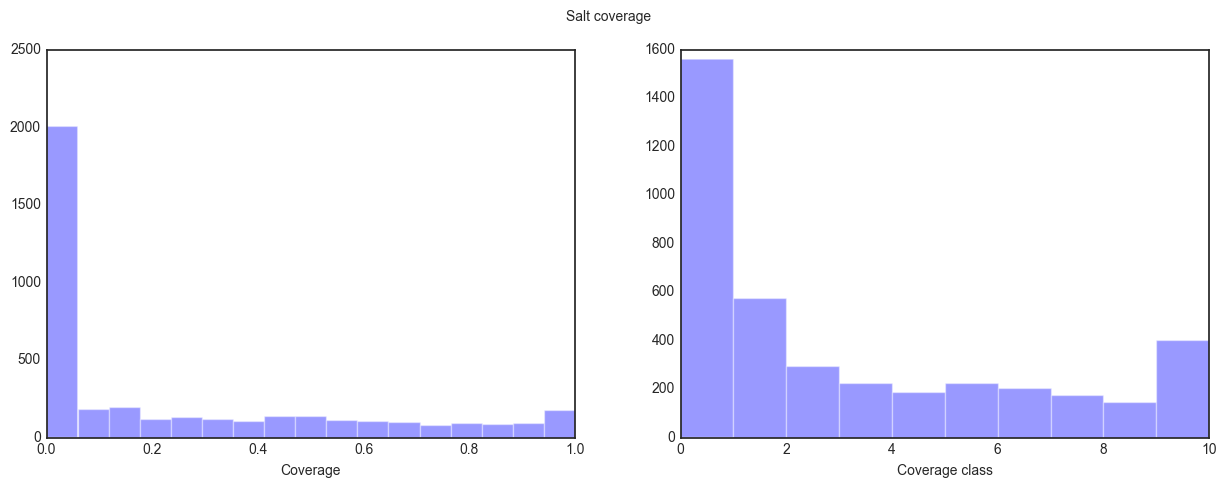

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

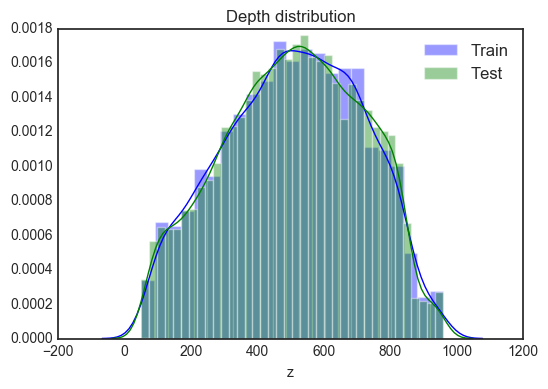

In [9]:
#Plotting the depth distributions¶
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [10]:
# Create train/validation split stratified by salt coverage
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(train_df.index.values, 
                 np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 train_df.coverage.values, 
                 train_df.z.values, 
                 test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [11]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [15]:
'''
Squeeze-and-Excitation ResNets
References:
    - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
    - []() # added when paper is published on Arxiv
'''
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Conv2D
from keras.layers import add
from keras.layers import multiply
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

#from se import squeeze_excite_block

__all__ = ['SEResNet', 'SEResNet50', 'SEResNet101', 'SEResNet154', 'preprocess_input', 'decode_predictions']


WEIGHTS_PATH = ""
WEIGHTS_PATH_NO_TOP = ""

from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras import backend as K


def squeeze_excite_block(input, ratio=16):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x



def SEResNet(input_shape=None,
             initial_conv_filters=64,
             depth=[3, 4, 6, 3],
             filters=[64, 128, 256, 512],
             width=1,
             bottleneck=False,
             weight_decay=1e-4,
             include_top=True,
             weights=None,
             input_tensor=None,
             pooling=None,
             classes=1000):
    """ Instantiate the Squeeze and Excite ResNet architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            initial_conv_filters: number of features for the initial convolution
            depth: number or layers in the each block, defined as a list.
                ResNet-50  = [3, 4, 6, 3]
                ResNet-101 = [3, 6, 23, 3]
                ResNet-152 = [3, 8, 36, 3]
            filter: number of filters per block, defined as a list.
                filters = [64, 128, 256, 512
            width: width multiplier for the network (for Wide ResNets)
            bottleneck: adds a bottleneck conv to reduce computation
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization) or `imagenet` (trained
                on ImageNet)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(224, 224, 3)` (with `tf` dim ordering)
                or `(3, 224, 224)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    assert len(depth) == len(filters), "The length of filter increment list must match the length " \
                                       "of the depth list."

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=False)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _create_se_resnet(classes, img_input, include_top, initial_conv_filters,
                          filters, depth, width, bottleneck, weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights

    return model


def SEResNet18(input_shape=None,
               width=1,
               bottleneck=False,
               weight_decay=1e-4,
               include_top=True,
               weights=None,
               input_tensor=None,
               pooling=None,
               classes=1000):
    return SEResNet(input_shape,
                    depth=[2, 2, 2, 2],
                    width=width,
                    bottleneck=bottleneck,
                    weight_decay=weight_decay,
                    include_top=include_top,
                    weights=weights,
                    input_tensor=input_tensor,
                    pooling=pooling,
                    classes=classes)


def SEResNet34(input_shape=None,
               width=1,
               bottleneck=False,
               weight_decay=1e-4,
               include_top=True,
               weights=None,
               input_tensor=None,
               pooling=None,
               classes=1000):
    return SEResNet(input_shape,
                    depth=[3, 4, 6, 3],
                    width=width,
                    bottleneck=bottleneck,
                    weight_decay=weight_decay,
                    include_top=include_top,
                    weights=weights,
                    input_tensor=input_tensor,
                    pooling=pooling,
                    classes=classes)


def SEResNet50(input_shape=None,
               width=1,
               bottleneck=True,
               weight_decay=1e-4,
               include_top=True,
               weights=None,
               input_tensor=None,
               pooling=None,
               classes=1000):
    return SEResNet(input_shape,
                    width=width,
                    bottleneck=bottleneck,
                    weight_decay=weight_decay,
                    include_top=include_top,
                    weights=weights,
                    input_tensor=input_tensor,
                    pooling=pooling,
                    classes=classes)


def SEResNet101(input_shape=None,
                width=1,
                bottleneck=True,
                weight_decay=1e-4,
                include_top=True,
                weights=None,
                input_tensor=None,
                pooling=None,
                classes=1000):
    return SEResNet(input_shape,
                    depth=[3, 6, 23, 3],
                    width=width,
                    bottleneck=bottleneck,
                    weight_decay=weight_decay,
                    include_top=include_top,
                    weights=weights,
                    input_tensor=input_tensor,
                    pooling=pooling,
                    classes=classes)


def SEResNet154(input_shape=None,
                width=1,
                bottleneck=True,
                weight_decay=1e-4,
                include_top=True,
                weights=None,
                input_tensor=None,
                pooling=None,
                classes=1000):
    return SEResNet(input_shape,
                    depth=[3, 8, 36, 3],
                    width=width,
                    bottleneck=bottleneck,
                    weight_decay=weight_decay,
                    include_top=include_top,
                    weights=weights,
                    input_tensor=input_tensor,
                    pooling=pooling,
                    classes=classes)


def _resnet_block(input, filters, k=1, strides=(1, 1)):
    ''' Adds a pre-activation resnet block without bottleneck layers
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
        strides: strides of the convolution layer
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('relu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != filters * k:
        init = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m


def _resnet_bottleneck_block(input, filters, k=1, strides=(1, 1)):
    ''' Adds a pre-activation resnet block with bottleneck layers
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
        strides: strides of the convolution layer
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    bottleneck_expand = 4

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('relu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != bottleneck_expand * filters * k:
        init = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m


def _create_se_resnet(classes, img_input, include_top, initial_conv_filters, filters,
                      depth, width, bottleneck, weight_decay, pooling):
    '''Creates a SE ResNet model with specified parameters
    Args:
        initial_conv_filters: number of features for the initial convolution
        include_top: Flag to include the last dense layer
        filters: number of filters per block, defined as a list.
            filters = [64, 128, 256, 512
        depth: number or layers in the each block, defined as a list.
            ResNet-50  = [3, 4, 6, 3]
            ResNet-101 = [3, 6, 23, 3]
            ResNet-152 = [3, 8, 36, 3]
        width: width multiplier for network (for Wide ResNet)
        bottleneck: adds a bottleneck conv to reduce computation
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)

    # block 1 (initial conv block)
    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # block 2 (projection block)
    for i in range(N[0]):
        if bottleneck:
            x = _resnet_bottleneck_block(x, filters[0], width)
        else:
            x = _resnet_block(x, filters[0], width)

    # block 3 - N
    for k in range(1, len(N)):
        if bottleneck:
            x = _resnet_bottleneck_block(x, filters[k], width, strides=(2, 2))
        else:
            x = _resnet_block(x, filters[k], width, strides=(2, 2))

        for i in range(N[k] - 1):
            if bottleneck:
                x = _resnet_bottleneck_block(x, filters[k], width)
            else:
                x = _resnet_block(x, filters[k], width)

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [38]:
# Build Model with SE
def build_model_2(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = squeeze_excite_block(pool1, ratio=16)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = squeeze_excite_block(pool2, ratio=16)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = squeeze_excite_block(pool3, ratio=16)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = squeeze_excite_block(pool4, ratio=16)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [17]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [18]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [19]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [20]:
#Data augmentation - 2
x_train = np.append(x_train, [np.flipud(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.flipud(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

In [39]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model_2(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.005)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_776 (Conv2D)             (None, 101, 101, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_756 (BatchN (None, 101, 101, 16) 64          conv2d_776[0][0]                 
__________________________________________________________________________________________________
activation_756 (Activation)     (None, 101, 101, 16) 0           batch_normalization_756[0][0]    
__________________________________________________________________________________________________
conv2d_777

In [40]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='my_iou_metric', mode='max',
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5,
                              min_lr=0.00005, verbose=1)

epochs = 200
batch_size = 128

t_model1_start = time.time()
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 2)
t_model1_end = time.time()

v={"tt":(t_model1_end-t_model1_start)/3600}
print("Run time = {(tt} hours".format(**v))

Train on 6400 samples, validate on 800 samples
Epoch 1/200


KeyboardInterrupt: 

In [ ]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})
# remove activation layer and use lovasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.01)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=10, 
                              min_lr=0.00005, verbose=1)
epochs = 200
batch_size = 64

t_model2_start = time.time()
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)
t_model2_end = time.time()
print(f"Run time = {(t_model2_end-t_model2_start)/3600} hours")

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [ ]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [ ]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [ ]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

In [ ]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")